In this notebook we analyse the stability of the layer conductance values from the model on a fixed train and test set. We are interested in how the random initialization of the weights influences the importance scores obtained for the genes.

Imports:

In [2]:
import pnet_loader
import util
import Pnet
import report_and_eval
import os
import torch
import seaborn as sns
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import wandb

%load_ext autoreload
%autoreload 2

Data Loading:

In [3]:
# DATADIR = '/mnt/disks/pancan' # Marc's
DATADIR = '../../pnet_germline/data' # Gwen's
SAVEDIR = '../../pnet/results/gene_rank_stability' # Gwen's

In [3]:
prostate_mutations = pd.read_csv(os.path.join(DATADIR, 'pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv'))
prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_cnv = pd.read_csv(os.path.join(DATADIR, 'pnet_database/prostate/processed/P1000_data_CNA_paper.csv'))
prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_response = pd.read_csv(os.path.join(DATADIR, 'pnet_database/prostate/processed/response_paper.csv'))
prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_genes = pd.read_csv(os.path.join(DATADIR, 'pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv'))
prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

# prostate_mutations = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
# prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_cnv = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
# prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
# prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_response = pd.read_csv('../../data/pnet_database/prostate/processed/response_paper.csv')
# prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
# prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_genes = pd.read_csv(os.path.join(DATADIR, 'pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv'))
prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

prostate_cnv = prostate_cnv[prostate_genes].copy()
prostate_mutations = prostate_mutations[prostate_genes].copy()

# prostate_genes = util.select_highly_variable_genes(prostate_mutations)
# prostate_genes = prostate_genes['level_1']
prostate_mutations = prostate_mutations[list(set(prostate_mutations.columns).intersection(prostate_genes))].copy()
prostate_cnv = prostate_cnv[list(set(prostate_cnv.columns).intersection(prostate_genes))].copy()

# Regenerate input as specified in prostate_paper
prostate_mutations = (prostate_mutations > 0).astype(int)
prostate_amp = (prostate_cnv > 1).astype(int)
prostate_del = (prostate_cnv < -1).astype(int)

In [4]:
genetic_data = {'mut': prostate_mutations, 'amp': prostate_amp, 'del': prostate_del}

In [5]:
test_inds = list(pd.read_csv(os.path.join(DATADIR, 'pnet_database/prostate/splits/test_set.csv'))['id'])
train_inds = list(pd.read_csv(os.path.join(DATADIR, 'pnet_database/prostate/splits/training_set.csv'))['id'])

# test_inds = list(pd.read_csv('/mnt/disks/pancan/pnet_database/splits/test_set.csv')['id'])
# train_inds = list(pd.read_csv('/mnt/disks/pancan/pnet_database/splits/training_set.csv')['id'])

Model training:

2023-12-17 16:53:06 ERROR    Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: millergw. Use `wandb login --relogin` to force relogin


Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (807, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (102, 14562)
Found 4854 overlapping genes
Loss function used: BCEWithLogitsLoss()
We are sending to cuda


2023-12-17 17:12:53 INFO     Making a loss plot over time


convergence for model 0


2023-12-17 17:12:54 INFO     saving plot to ../../pnet/results/gene_rank_stability/loss_over_time_0


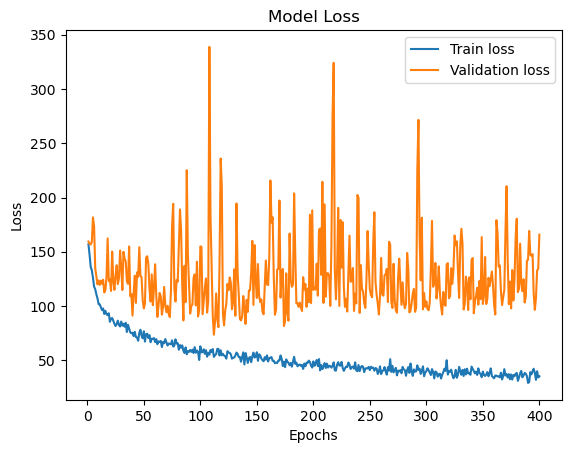

Test Loss,▇▄▄▆▅▆▃▂▄▃▄▁▄▂▄▂█▅▆▃▃▆█▂▄▃▆▆▃█▅▃▅▄▃▄▃▅▃▇
Train Loss,█▆▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁
Test Loss,165.7721
Train Loss,35.33858


In [6]:
wandb.login()

gene_imps = []
layerwise_imps = []
aucs = []
for r in range(1):
    wandb.init(
        # Set the project where this run will be logged
        project="prostate_met_status",
        name=f"gene_stability_somatic_{r}"
    )
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         prostate_response,
                                                                         verbose=False,
                                                                         early_stopping=False,
                                                                         train_inds=train_inds,
                                                                         test_inds=test_inds)
    model.to('cpu')
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y
    pred = model(x_test, additional_test)
    y_pred_proba = pred[0].detach().numpy().squeeze()
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    aucs.append(metrics.roc_auc_score(y_test, y_pred_proba))
    gene_imps.append(model.gene_importance(test_dataset))
    layerwise_imps.append(model.layerwise_importance(test_dataset))

    print(f"convergence for model {r}")
    plt = report_and_eval.get_loss_plot(train_losses=train_scores, test_losses=test_scores)
    report_and_eval.savefig(plt, os.path.join(SAVEDIR, f'loss_over_time_{r}'))
    plt.show()
    
    wandb.finish()
    

In [7]:
print(type(gene_imps[0]))
print(type(layerwise_imps[0]))
print(type(aucs[0]))

<class 'pandas.core.frame.DataFrame'>
<class 'list'>
<class 'numpy.float64'>


In [ ]:
# Gwen 
pd.concat(gene_imps, axis=1).std(axis=1).nlargest(20)
pd.concat([gis.rank(ascending=False) for gis in gene_imps], axis=1).mean(axis=1).nsmallest(20)

In [38]:
pd.concat(gene_imps, axis=1).std(axis=1).nlargest(20)

AR         4.853938
TP53       2.594748
PTEN       2.158988
FNDC1      1.951894
SLC45A4    1.296950
PHLDB2     1.131713
KLHDC8A    1.094294
GPBP1      1.047550
TATDN1     0.949547
PHF20L1    0.885988
ZNF34      0.835381
RAB14      0.804577
BACH2      0.790045
ZMIZ1      0.787808
MAP3K7     0.787134
HSPA6      0.775397
SCRT1      0.741248
FAT4       0.719318
ZNF250     0.706913
PXDNL      0.661662
dtype: float32

In [53]:
pd.concat([gis.rank(ascending=False) for gis in gene_imps], axis=1).mean(axis=1).nsmallest(20)

AR         1.00
TP53       2.15
PTEN       2.85
MDM4      12.50
MED30     12.80
ASB18     17.60
UBE2W     23.85
KBTBD8    27.80
ZNF92     38.65
RB1       41.65
MDM2      42.35
PSMD1     43.15
MGA       44.50
ZNF184    48.65
NR3C2     49.10
RBBP5     50.80
RNF123    52.75
MAML3     54.75
PTPRJ     55.85
CUL9      56.10
dtype: float64

In [32]:
pd.concat(gene_imps, axis=1).mean(axis=1).loc[['AR', 'TP53','PTEN', 'RB1', 'MDM4', 'FGFR1', 'MAML3', 'PDGFA', 'NOTCH1', 'EIF3E']]

AR        28.339069
TP53      10.345586
PTEN       8.134116
RB1        0.711618
MDM4       1.484305
FGFR1     -0.136983
MAML3      0.622123
PDGFA      0.456059
NOTCH1     0.000000
EIF3E      0.065069
dtype: float32

In [55]:
pd.concat([gis.rank(ascending=False) for gis in gene_imps], axis=1).mean(axis=1).rank(ascending=True).loc[['AR', 'TP53','PTEN', 'RB1', 'MDM4', 'FGFR1', 'MAML3', 'PDGFA', 'NOTCH1', 'EIF3E']]

AR           1.0
TP53         2.0
PTEN         3.0
RB1         10.0
MDM4         4.0
FGFR1     4764.0
MAML3       18.0
PDGFA       55.0
NOTCH1    2407.0
EIF3E      515.0
dtype: float64

In [39]:
pd.concat(gene_imps, axis=1).std(axis=1).rank(ascending=False).loc[['AR', 'TP53','PTEN', 'RB1', 'MDM4', 'FGFR1', 'MAML3', 'PDGFA', 'NOTCH1', 'EIF3E']]

AR           1.0
TP53         2.0
PTEN         3.0
RB1        155.0
MDM4        36.0
FGFR1      337.0
MAML3      136.0
PDGFA       70.0
NOTCH1    3969.5
EIF3E      419.0
dtype: float64

# Scratch exploration

In [4]:
import pickle

# Read gene_imps from a Pickle file (format: len 20 list --> pandas DFs, samples x genes?)
with open(os.path.join(SAVEDIR, 'gene_imps.pkl'), 'rb') as file:
    gene_imps = pickle.load(file)

# Read layerwise_imps from a Pickle file (format: len 20 list --> len 5 list --> pandas DF, samples x features)
with open(os.path.join(SAVEDIR, 'layerwise_imps.pkl'), 'rb') as file:
    layerwise_imps = pickle.load(file)

In [5]:
gene_imps[0].shape

(102, 4854)

In [6]:
for i in range(5):
    print(layerwise_imps[0][i].shape)

(102, 734)
(102, 845)
(102, 449)
(102, 159)
(102, 29)


In [7]:
# Concatenate the gene_imps list along rows (axis=0)
concatenated_data = pd.concat(gene_imps, axis=0)

# Display the concatenated DataFrame
print("Concatenated Data:")
print(concatenated_data)


# Calculate the standard deviation for each gene across runs (these might be most "informative")
gene_std_devs = concatenated_data.std(axis=0)

# Display the standard deviations
print("Standard Deviations for Each Gene:")
print(gene_std_devs)

# Choose the number of top genes you want to identify
top_n = 50

# Find the top N genes with the highest standard deviation
top_genes = gene_std_devs.abs().nlargest(top_n).index

# Display the top genes
print(f"Top {top_n} Genes:")
print(top_genes)



Concatenated Data:
                                        POGZ     MAT2A  HSPD1  HARS  STARD7  \
TCGA-HC-7077                        0.000000  0.000000    0.0   0.0     0.0   
TP_2020                             0.000000  0.000000    0.0   0.0     0.0   
01-095N1_LN                         0.000000  0.000000    0.0   0.0     0.0   
MO_1124                             0.000000  0.000000    0.0   0.0     0.0   
TP_2077                             0.000000  0.000000    0.0   0.0     0.0   
...                                      ...       ...    ...   ...     ...   
PM154                               0.000000  0.000000    0.0   0.0     0.0   
AAPC-STID0000007180-Tumor-SM-2XU14  0.000026  0.066554    0.0   0.0     0.0   
AAPC-STID0000021611-Tumor-SM-2XU18  0.000000  0.000000    0.0   0.0     0.0   
AAPC-STID0000021614-Tumor-SM-2XU1O  0.000040  0.072734    0.0   0.0     0.0   
TCGA-KK-A7B1                        0.000000  0.000000    0.0   0.0     0.0   

                                

## Find percentage of time each gene is in the top 50 most important genes in predicting metastatic patients
1. Filter to met patients
Per patient stability: %top 50 for each gene across the 20 runs
OR Collapse/average across patients --> overall top 50 stability (to check if model has multi-state solution of sorts)




gene_imps

In [22]:
# Extract the first row from each DataFrame
first_rows = [df.iloc[0] for df in gene_imps]

# Create a DataFrame with the first rows
first_rows_df = pd.DataFrame(first_rows)

# Create a DataFrame with rankings for each gene in each row
rankings_df = first_rows_df.apply(lambda row: row.abs().rank(ascending=False), axis=1)


In [32]:
rankings_df

,POGZ,MAT2A,HSPD1,HARS,STARD7,DR1,ARFGAP2,NSUN4,CRYGA,CYP4V2,...,NAP1L4,STK33,USO1,TEX261,WNT16,SUPT7L,NSUN7,HNRNPR,SARS,PLCXD2
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0
TCGA-HC-7077,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,...,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5,2440.5
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0
TCGA-HC-7077,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,...,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0,2440.0


In [46]:
stabs = []
for patient_i in range(gene_imps[0].shape[0]):
    # Extract the first row from each DataFrame
    first_rows = [df.iloc[patient_i] for df in gene_imps]

    # Create a DataFrame with the first rows
    first_rows_df = pd.DataFrame(first_rows)

    # Create a DataFrame with rankings for each gene in each row
    rankings_df = first_rows_df.apply(lambda row: row.abs().rank(ascending=False), axis=1)

    # Compute the average and standard deviation across rows
    average_across_rows = rankings_df.mean(axis=0)
    std_across_rows = rankings_df.std(axis=0)

    # Create a new DataFrame with averages and standard deviations
    summary_df = pd.DataFrame({
        'Average Across Rows': average_across_rows,
        'Std Dev Across Rows': std_across_rows
    })
    summary_df = summary_df.sort_values(by='Average Across Rows', ascending=True)

    filtered_to_imp = summary_df[summary_df['Average Across Rows']<50]
    stability_metric = filtered_to_imp['Std Dev Across Rows'].median()
    stabs.append(stability_metric)
stabs


[5.554514522345527,
 25.20809363938451,
 14.359308329889025,
 12.955287479797988,
 46.445072255752876,
 24.951479230487994,
 2.154554539378824,
 3.6569962474127804,
 29.173888830145426,
 10.600058253677547,
 21.84701593497743,
 12.979231633646865,
 24.618522187114884,
 nan,
 28.47360426664963,
 7.55941378958086,
 21.736701923850262,
 34.869892600431854,
 33.47092217999001,
 1.8431951662948314,
 46.287971610230166,
 10.091554572225755,
 22.622017170112642,
 6.348435364634924,
 33.197573529468244,
 2.9363603857966,
 2.258023441892534,
 1.0480855426566023,
 36.445540011959054,
 10.336126689220443,
 5.495036599920141,
 0.7535577114106915,
 15.517488280772483,
 1.9166857359844665,
 17.27334423476333,
 24.76542581482244,
 28.164927798500333,
 16.991034477096175,
 8.094426213493197,
 34.804718373413564,
 30.46114868069437,
 12.787740839940168,
 22.32882253477495,
 2.5772282132473046,
 4.793361637668671,
 2.1925042921489877,
 23.186322211446004,
 28.780658710138546,
 52.49100173513452,
 24.314

(array([20., 10.,  8., 10., 25., 11., 12.,  1.,  2.,  1.]),
 array([ 0.75355771,  5.92730211, 11.10104652, 16.27479092, 21.44853532,
        26.62227972, 31.79602413, 36.96976853, 42.14351293, 47.31725733,
        52.49100174]),
 <BarContainer object of 10 artists>)

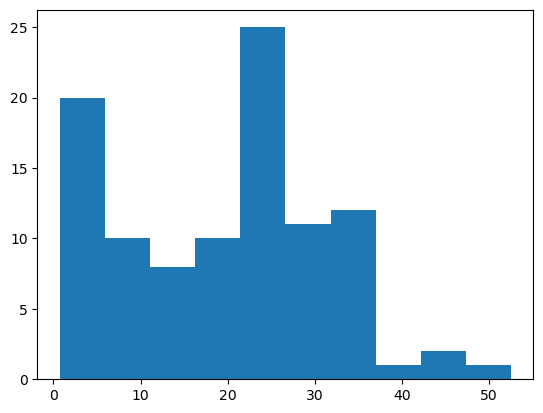

In [49]:
# median stdev of top 50 genes (top 50 relative to each patient). 
# Pretty darn unstable. 
# For example, a gene at rank 50 with a stdev of 50 means that 68% of the time, its rank was between 0 and 100.
plt.hist(stabs)

(array([1., 2., 1., 0., 0., 1., 2., 2., 2., 2., 4., 0., 0., 0., 3., 3., 0.,
        0., 0., 2.]),
 array([ 4.5  ,  5.355,  6.21 ,  7.065,  7.92 ,  8.775,  9.63 , 10.485,
        11.34 , 12.195, 13.05 , 13.905, 14.76 , 15.615, 16.47 , 17.325,
        18.18 , 19.035, 19.89 , 20.745, 21.6  ]),
 <BarContainer object of 20 artists>)

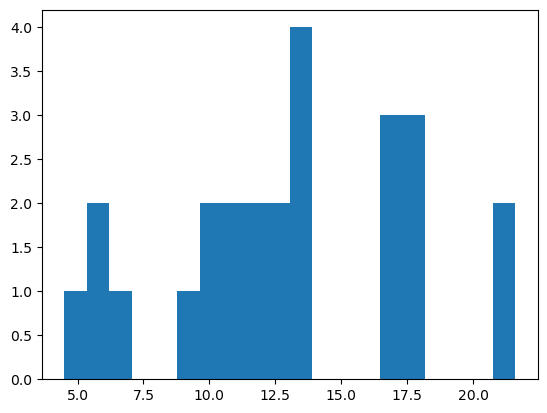

In [41]:
plt.hist(summary_df[summary_df['Average Across Rows']<200]['Average Across Rows'], bins=20)


In [31]:
rankings_df.iloc[0,:].value_counts()

2440.0    4829
4.0          1
14.0         1
21.0         1
19.0         1
18.0         1
22.0         1
16.0         1
20.0         1
15.0         1
3.0          1
23.0         1
17.0         1
9.0          1
1.0          1
12.0         1
5.0          1
7.0          1
24.0         1
2.0          1
13.0         1
11.0         1
6.0          1
10.0         1
25.0         1
8.0          1
Name: TCGA-HC-7077, dtype: int64

In [21]:
# Extract the first row from each DataFrame
first_rows = [df.iloc[0] for df in gene_imps]

# Create a new DataFrame by concatenating the first rows
first_rows_df = pd.concat(first_rows, axis=1).transpose()

# Calculate the average across rows
average_across_rows = first_rows_df.mean(axis=0)

# Display the results
print("First Rows:")
print(first_rows_df)
print("\nAverage Across Rows:")
print(average_across_rows)

First Rows:
              POGZ  MAT2A  HSPD1  HARS  STARD7  DR1  ARFGAP2  NSUN4  CRYGA  \
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0      0.0    0.0    0.0   
TCGA-HC-7077   0.0    0.0    0.0   0.0     0.0  0.0 

In [22]:
average_across_rows

POGZ      0.0
MAT2A     0.0
HSPD1     0.0
HARS      0.0
STARD7    0.0
         ... 
SUPT7L    0.0
NSUN7     0.0
HNRNPR    0.0
SARS      0.0
PLCXD2    0.0
Length: 4854, dtype: float32

In [23]:
# Create a bar plot
plt.bar(average_across_rows.index, average_across_rows.values, color='blue')

# Set plot labels and title
plt.xlabel('Genes')
plt.ylabel('Average Value Across Rows')
plt.title('Average Across Rows for Each Gene')

# Show the plot
plt.show()

KeyboardInterrupt: 

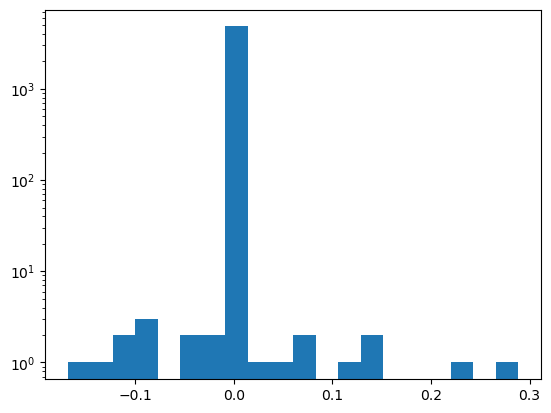

In [26]:
plt.hist(average_across_rows.values, bins=20)
plt.yscale('log')

In [31]:
# Create a DataFrame with both original and absolute values
sorted_df = pd.DataFrame({
    'Original': average_across_rows,
    'Absolute': average_across_rows.abs()
})

# Sort the DataFrame by absolute values
sorted_df = sorted_df.sort_values(by='Absolute', ascending=False)
sorted_df[:50]

,Original,Absolute
LRRC41,2.887433e-01,2.887433e-01
FGD5,2.288671e-01,2.288671e-01
STX17,-1.685445e-01,1.685445e-01
KLHL3,1.476849e-01,1.476849e-01
NRXN1,1.375181e-01,1.375181e-01
PNPLA1,-1.235605e-01,1.235605e-01
LARP4B,1.197710e-01,1.197710e-01
KCNQ1,-1.064788e-01,1.064788e-01
NR4A3,-1.012705e-01,1.012705e-01
ERP44,-9.810662e-02,9.810662e-02
